## Importing the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir(os.path.dirname(os.getcwd()))


In [4]:
df = pd.read_excel('data/2022_2025_Faculty Load Analysis w. Class # - CLEANED.xlsx')
df.shape

(4559, 23)

## Segregating the Graduate Courses from Undergrad Courses

In [5]:

# Ensure Catalog Number is numeric
df['Catalog Number'] = pd.to_numeric(df['Catalog Number'], errors='coerce')

# Filter for graduate‐level courses (Catalog Number ≥ 500)
df_grad = df[df['Catalog Number'] >= 500]

# Save the graduate subset to a new Excel file
output_path = 'data/faculty_load_grad.xlsx'
df_grad.to_excel(output_path, index=False)

print(f"Saved graduate‐level data to: {output_path}")

Saved graduate‐level data to: data/faculty_load_grad.xlsx


## Understanding the Data Set

In [8]:
# Initial dimentions of data
print("Dataset shape:", df_grad.shape)

Dataset shape: (2107, 23)


In [9]:
# Data types
df_grad.dtypes

Term                                             object
Session                                          object
Class Campus                                     object
Class College                                    object
Subject                                          object
Subject Code                                     object
Catalog Number                                  float64
Class Section                                    object
Course Offering Number                            int64
Component                                        object
Course ID                                         int64
Instruction Mode                                 object
Class Meeting Number                            float64
Psuedonymn                                       object
Instructor Load Factor                          float64
Instructor Role                                  object
Total Instructor                                  int64
Class Section Total Enrollment                  

In [10]:
# Statistical summary of numerical columns
df_grad.describe()

,Catalog Number,Course Offering Number,Course ID,Class Meeting Number,Instructor Load Factor,Total Instructor,Class Section Total Enrollment,Class Section Total Enrollment2,Enrollment Capacity,Total Student Headcount Including Withdrawal,Units,Class Number
count,2107.000000,2107.000000,2107.000000,2103.000000,2066.000000,2107.000000,2107.000000,2107.0,2107.000000,2107.000000,1527.000000,2107.000000
mean,606.551020,1.168486,31441.217845,1.000476,87.872217,0.980541,12.628856,1.0,32.696725,6.078784,2.973805,68789.453251
std,97.774823,0.381920,10193.504977,0.021806,31.103734,0.138164,20.485765,0.0,32.468666,8.991884,0.802581,16384.508140
min,501.000000,1.000000,18156.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,10002.000000
25%,526.000000,1.000000,18220.000000,1.000000,100.000000,1.000000,0.000000,1.0,5.000000,0.000000,3.000000,57046.500000
50%,570.000000,1.000000,37929.000000,1.000000,100.000000,1.000000,3.000000,1.0,30.000000,2.000000,3.000000,69237.000000
75%,692.000000,1.000000,39655.000000,1.000000,100.000000,1.000000,16.000000,1.0,40.000000,9.000000,3.000000,77722.000000
max,920.000000,3.000000,43170.000000,2.000000,100.000000,1.000000,120.000000,1.0,140.000000,102.000000,9.000000,99991.000000


## Check for Duplicates

In [11]:
# Number of duplicate rows
num_duplicates = df_grad.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 5


In [12]:
# Removeing duplicate rows and saving this as df
if num_duplicates > 0:
    df = df_grad.drop_duplicates()
    print("Duplicates dropped. New shape:", df.shape)

Duplicates dropped. New shape: (2102, 23)


## Check for missing values

In [13]:
# Checking for missing values in each column
print("Missing values in each column:")
print(df_grad.isnull().sum())

Missing values in each column:
Term                                              0
Session                                           0
Class Campus                                      0
Class College                                     0
Subject                                           0
Subject Code                                      0
Catalog Number                                    0
Class Section                                     0
Course Offering Number                            0
Component                                         0
Course ID                                         0
Instruction Mode                                  0
Class Meeting Number                              4
Psuedonymn                                        0
Instructor Load Factor                           41
Instructor Role                                   0
Total Instructor                                  0
Class Section Total Enrollment                    0
Class Section Total Enrollment2  

In [14]:
# 1. Drop sparse columns
threshold = len(df_grad) * 0.5
df_grad = df_grad.dropna(axis=1, thresh=threshold)

# 2. Drop rows missing Class Meeting Number
df_grad = df_grad.dropna(subset=['Class Meeting Number'])

# 3. Impute numeric
num_cols = df_grad.select_dtypes(include='number').columns
for col in num_cols:
    df_grad[col] = df_grad[col].fillna(df_grad[col].median())

# 4. Impute categorical
cat_cols = df_grad.select_dtypes(include=['object','category']).columns
for col in cat_cols:
    mode_vals = df_grad[col].mode()
    fill_val = mode_vals[0] if not mode_vals.empty else 'Unknown'
    df_grad[col] = df_grad[col].fillna(fill_val)

# 5. Verify
print("Missing values in each column:")
print(df_grad.isnull().sum())


Missing values in each column:
Term                                            0
Session                                         0
Class Campus                                    0
Class College                                   0
Subject                                         0
Subject Code                                    0
Catalog Number                                  0
Class Section                                   0
Course Offering Number                          0
Component                                       0
Course ID                                       0
Instruction Mode                                0
Class Meeting Number                            0
Psuedonymn                                      0
Instructor Load Factor                          0
Instructor Role                                 0
Total Instructor                                0
Class Section Total Enrollment                  0
Class Section Total Enrollment2                 0
Enrollment Capacity

## Removing independent study, Colloquium and Laboratory from column "Component"

In [15]:
# 1. Define the values to remove (case‐sensitive match)
to_remove = ['Independent Study', 'Colloquium', 'Laboratory']

# 2. Filter them out
df_filtered = df[~df['Component'].str.strip().isin(to_remove)].reset_index(drop=True)

# 3. Preview the result
print(df_filtered['Component'].unique())

# Save the filtered dataset to a new Excel file
df_faculty_load_filtered_file_path = 'data/df_faculty_load_filtered.xlsx'
df_filtered.to_excel(df_faculty_load_filtered_file_path, index=False)
print("Dataset shape:", df_filtered.shape)

['Lecture']
Dataset shape: (1534, 23)


## Categorical Analysis

Frequency counts for 'Term':
             count
Term              
Spring 2024    238
Fall 2021      233
Fall 2023      210
Fall 2024      199
Spring 2023    190
Spring 2025    178
Fall 2022      161
Spring 2022    125




<Figure size 700x400 with 0 Axes>

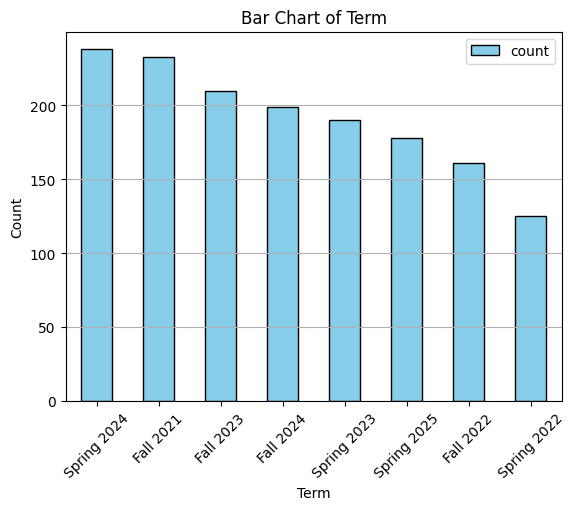

Frequency counts for 'Session':
                           count
Session                         
Regular Academic Session     965
Carry-over Course            188
Dynamically Dated Session    169
Seven Week - Second          110
Seven Week - First           102




<Figure size 700x400 with 0 Axes>

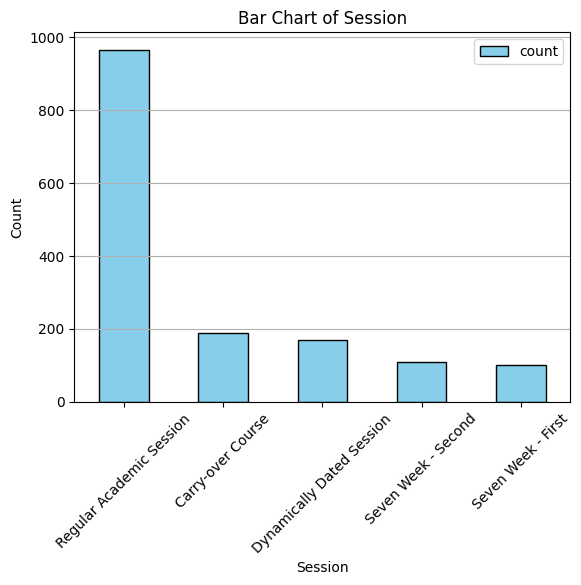

Frequency counts for 'Class Campus':
                              count
Class Campus                       
University of Arizona - Main    610
Arizona Online                  378
Arizona International           373
Arizona International Direct    173




<Figure size 700x400 with 0 Axes>

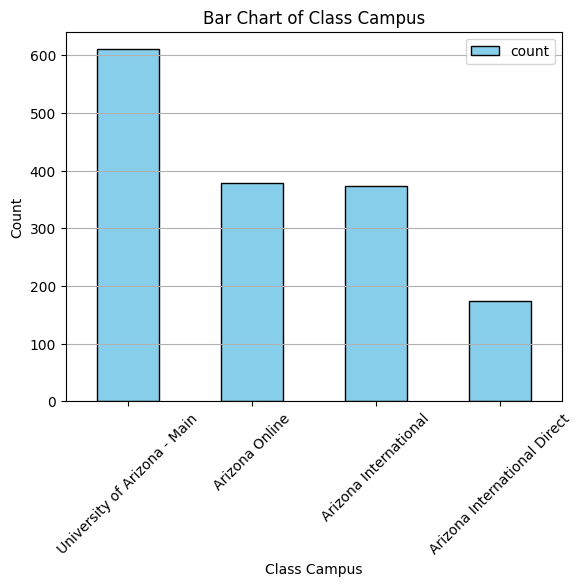

Frequency counts for 'Class College':
                                count
Class College                        
College of Information Science   1534




<Figure size 700x400 with 0 Axes>

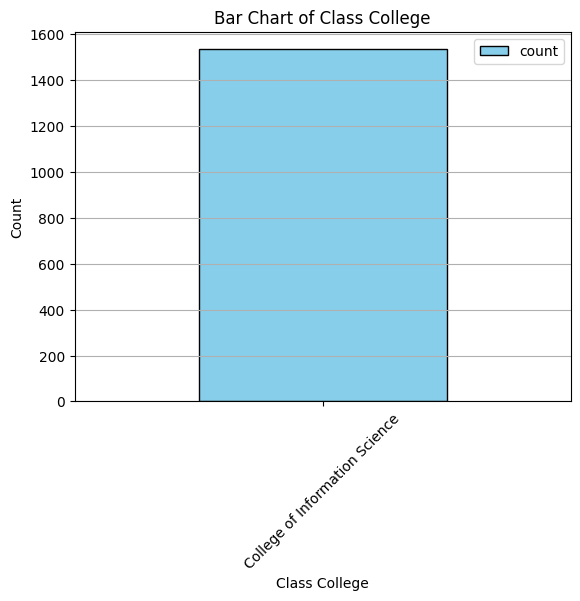

Frequency counts for 'Subject':
                               count
Subject                             
Information                      890
Library & Information Science    630
Biosystems Engineering             6
Plant Science                      6
Game Design, Dev., & Behavior      2




<Figure size 700x400 with 0 Axes>

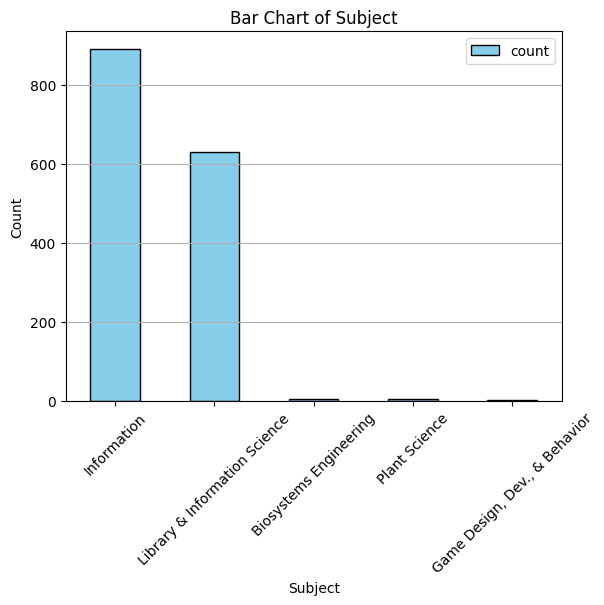

Frequency counts for 'Subject Code':
              count
Subject Code       
INFO            890
LIS             630
BE                6
PLS               6
GAME              2




<Figure size 700x400 with 0 Axes>

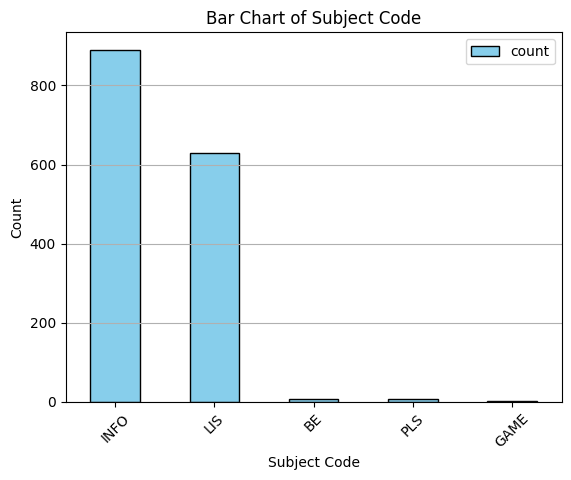

Frequency counts for 'Component':
           count
Component       
Lecture     1534




<Figure size 700x400 with 0 Axes>

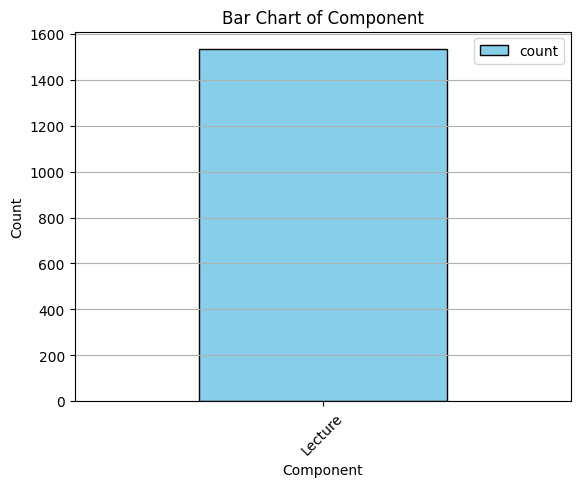

Frequency counts for 'Instruction Mode':
                         count
Instruction Mode              
Fully Online              1336
In Person                  182
Live Online                 14
Hybrid (Flex In-Person)      2




<Figure size 700x400 with 0 Axes>

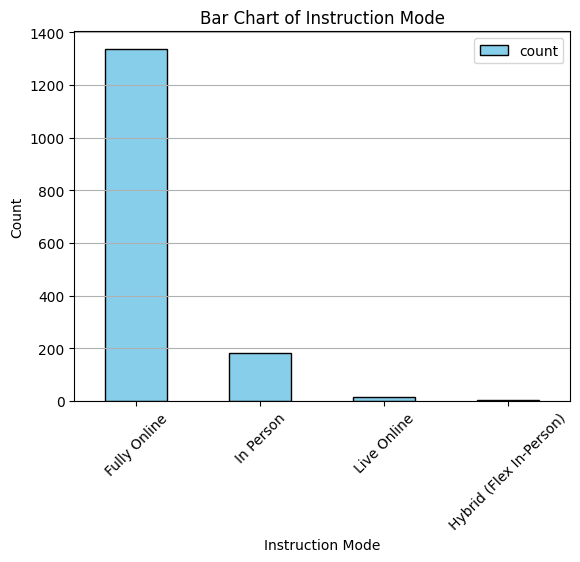

Frequency counts for 'Psuedonymn':
                     count
Psuedonymn                
Rivera, Rowan          116
Bennett, Hazel R       101
Medina, Gabriel         98
-                       89
Moretti, Julia May      59
...                    ...
Murphy,Dylan Joseph      1
Morrison,Clayton T       1
Bethard,Steven           1
Boz,Ren                  1
Boz,Lila                 1

[113 rows x 1 columns]


Frequency counts for 'Instructor Role':
                          count
Instructor Role                
Primary Instructor         1176
Department Administrator    323
Not Available                35




<Figure size 700x400 with 0 Axes>

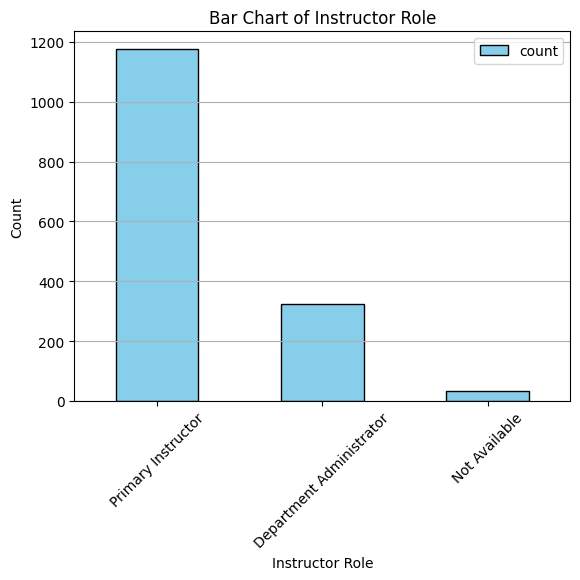

In [16]:
# (Re-)load the data
df = pd.read_excel('data/df_faculty_load_filtered.xlsx')

# Frequency and Bar Charts for Categorical Variables
# Looping through all categorical variables to display their frequency counts
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    # Print frequency counts
    freq = pd.DataFrame(df[col].value_counts())
    print(f"Frequency counts for '{col}':")
    print(freq)
    print("\n")


       # Plot bar chart if there are not too many categories
    if len(freq) < 15:
        plt.figure(figsize=(7, 4))
        freq.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f"Bar Chart of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.show()

## Overall Findings

The dataset originally contained **2,107 graduate-level course offerings** (filtered using Catalog Number ≥ 500).

**5 duplicate rows** were identified and removed, resulting in **2,102 records** in the cleaned graduate dataset.

We then filtered out all Independent Study, Colloquium, and Laboratory components as we are focusing on Lecture course only. After this filter, the dataset contains **1,534 rows**. This filtered data is suitable for general course demand and CBI insights.

**Column Types:**

Numerical Columns: 12 

Categorical Columns: 11 
